In [123]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
from matplotlib import dates
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from pprint import pprint
from cloudmesh.common.dotdict import dotdict
import numpy as np
import datetime
import time

# This notebook creates shaded line plots of power draw (W) over time (s).

If you get an error when running this notebook, please update numpy.
`pip install numpy -U`

Additionally, ensure that you have downloaded the data by using `make fetch`. This fetch command does not work on Windows, so run it in WSL.

In [124]:
# list_of_dirs = [
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]

list_of_dirs = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]
                     # ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35', 35)]
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25', 25)
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29', 29),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33', 33),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35', 35)]


In [125]:
files = []
for directory, epoch in list_of_dirs:
    gpulog = os.path.join(Path(directory), "gpu0.log")
    eventlog = glob.glob(f"{directory}/*.err")[0]
    files.append(dotdict(
        {
            "epoch" : epoch,
            "eventlog": eventlog,
            "gpulog": gpulog
        })
    )

pprint (files)

[{'epoch': 2,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\dje5dj-45737981.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\gpu0.log'},
 {'epoch': 30,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\dje5dj-45737982.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\gpu0.log'},
 {'epoch': 70,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\dje5dj-45737983.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\gpu0.log'},
 {'epoch': 2,
  'eventlog': './data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\dje5dj-44848919.err',
  'gpulog': 'data\\card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\gpu0.log'},
 {'epo

In [126]:
def convert_column_to_seconds(df, col):
    # df[[name]] = df[[name]].astype('datetime64[us]')
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # df[[name]] = pd.to_datetime(df[[name]], errors='coerce')
    start_t = df[col].iloc[0]
    print (start_t, type(start_t))
    for index, row in df.iterrows():

        delta = df.loc[index, col] - start_t
        df.loc[index, col] = delta.total_seconds()
    # df[name_of_seconds_column] = df[name] - start_t
    # df[[name]] = df[[name]].astype(int)/1000000000
    return df

def fix_date_format(df, col):
    # if We have T in it, we do not need to fix
    for i, row in df.iterrows():
        value = df.loc[i,col]
        if "T" not in value:
            new_date = df.loc[i,col].replace(":", " ", 1)
            df.loc[i,col] = new_date
    df[col] = pd.to_datetime(df[col])
    return df

In [127]:
def read_energy(filename=None):
    location = Shell.map_filename(filename).path
    # 1: means removing hashes
    content = readfile(location).splitlines()[1:]
    # removing #
    content[0] = content[0][2:]
    # print(content[0:10])
    content = "\n".join(content)
    content = content.replace(', ', ',')
    df = pd.read_csv(io.StringIO(content),sep=',')

    df = fix_date_format(df, "time")
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    return df


In [128]:
def read_eventlog(filename):
    location = Shell.map_filename(filename).path
    content = readfile(location, encoding='utf-8')
    content = content.replace(', ', ',').splitlines()

    # headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
    headline = Shell.cm_grep(content, '# csv,timer')[0]
    csv_lines = Shell.cm_grep(content, '# csv')
    csv_lines = Shell.cm_grep(csv_lines, 'Linux')
    csv_lines.insert(0, headline)
    # print("\n".join(csv_lines))
    content = "\n".join(csv_lines)
    df = pd.read_csv(io.StringIO(content),sep=',')
    df = df.rename(columns={'time':'dt'})
    df = df.rename(columns={'start':'time'})
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    df = df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
    t = df.pop("time")
    df.insert(0, "time", t)
    return df

In [129]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

In [130]:
def plot_events_and_energy(energylog, eventlog, epoch):
    energylog.rename(columns = {'0 power_draw W': epoch}, inplace=True)

    sns.set(font_scale=1.2)
    ax = sns.lineplot(x='time',
                      y=epoch,
                      data=energylog)
    plt.ylabel('Power draw (W)')
    plt.xlabel(f'Time (s)')

    shadow_x = [0]
    shadow_y = [0]

    last_time = energylog.iloc[-1]["time"]

    poi = {
        'INIT': "Initialize", # ok
        #'TFTdfTotalSpec event_num:0',
        #'data head setup',
        'RunTFTCustomVersion A': "Training", # ok

        #'RunTFTCustomVersion Train Loss Val Loss event_num:0',
        #'RunTFTCustomVersion bestfit Epoch:0',
        #'RunTFTCustomVersion bestfit Network attn layer attention summary timer_num:0',
        'RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0': "Bestfit Prediction", # ok

        'RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0': "Visualize",# ok

        #'RunTFTCustomVersion bestfit finalize',
        # 'DLprediction Iteration',

        'result': "Final plots",

        # 'DLResults_Graphs timer_num:0',
        # 'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0'
        '': "Completed"
    }

    for i, row in eventlog.iterrows():
       label = row['timer']

       if label in poi.keys():
          # print(row['timer'], row['start'])
          x = row['time']
          y = 180
          print(x, type(x), y, type(y), label, type(label))
          display_label = poi[label]
          print(display_label)
          ax.text(x, y, display_label, rotation=45)
          ax.plot(x, y)
          shadow_x.append(x)
          shadow_y.append(y)

    shadow_x.append(last_time)
    shadow_y.append(0)

    print (shadow_x)
    print (shadow_y)
    color = ["yellow","red","green","magenta","black","blue"]

    n = len(shadow_x)
    for i in range(0,n-1):
        x0 = shadow_x[i]
        x1 = shadow_x[i+1]
        plt.fill_betweenx(range(180), x0, x1, color=color[i], alpha=.1)

    # # export_figure('Time', 'Energy', filename)
    # return ax
    #sns.lineplot(x="time", y=epoch, data=energylog)

Generate output for Epoch 2
25.43566700000156 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1665.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
2936.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
5582.435667000002 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
9632.435667000002 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43566700000156, 1665.4356670000016, 2936.4356670000016, 5582.435667000002, 9632.435667000002, 9896.630569]
[0, 180, 180, 180, 180, 180, 0]


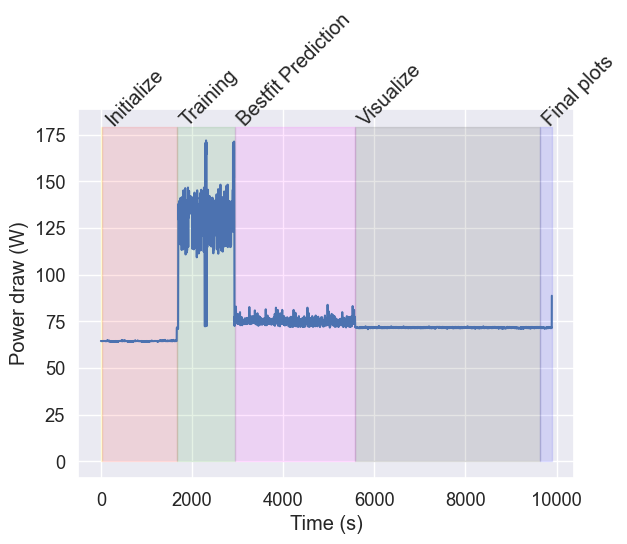

Generate output for Epoch 30
25.461425000001327 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1686.4614250000013 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
19730.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
22337.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
26513.461425 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.461425000001327, 1686.4614250000013, 19730.461425, 22337.461425, 26513.461425, 26778.975483]
[0, 180, 180, 180, 180, 180, 0]


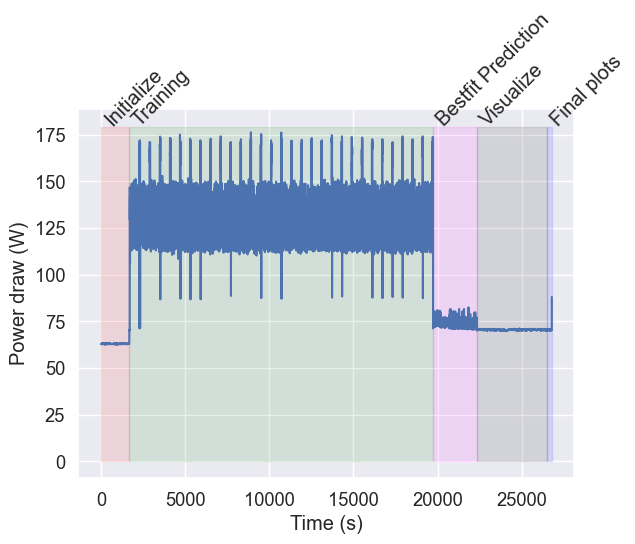

Generate output for Epoch 70
25.43237500000032 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1691.4323750000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
43460.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
45980.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
50199.432375000004 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43237500000032, 1691.4323750000003, 43460.432375, 45980.432375, 50199.432375000004, 50463.553789]
[0, 180, 180, 180, 180, 180, 0]


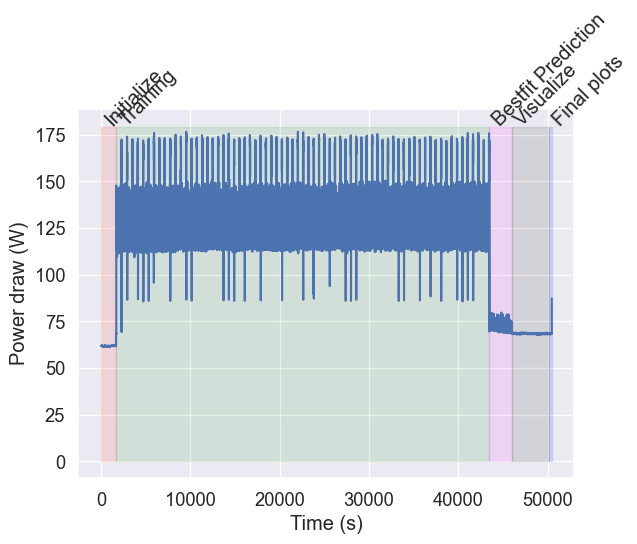

Generate output for Epoch 2
17.55613000000085 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
2189.556130000001 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
3797.556130000001 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
10050.55613 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
13542.55613 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 17.55613000000085, 2189.556130000001, 3797.556130000001, 10050.55613, 13542.55613, 13779.560746]
[0, 180, 180, 180, 180, 180, 0]


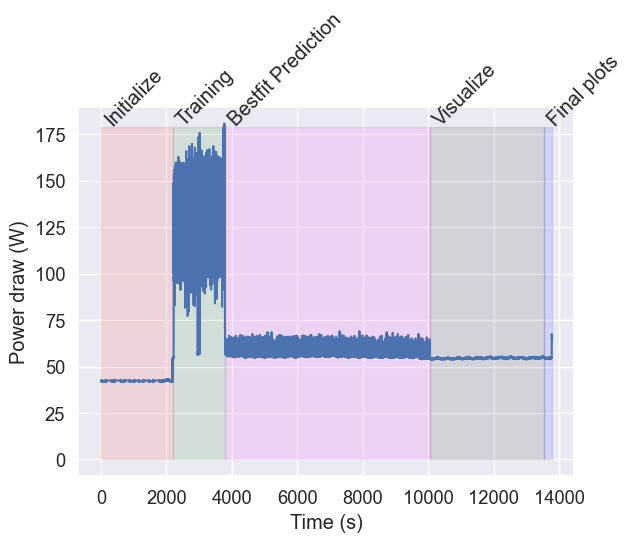

Generate output for Epoch 30
17.56590000000142 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1811.5659000000014 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
22973.5659 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
27377.5659 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
30377.5659 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 17.56590000000142, 1811.5659000000014, 22973.5659, 27377.5659, 30377.5659, 30575.876815]
[0, 180, 180, 180, 180, 180, 0]


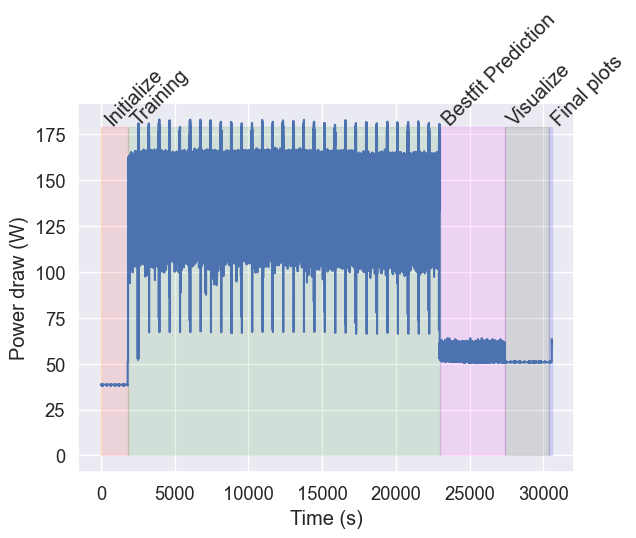

Generate output for Epoch 70
19.276130999998713 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1831.2761309999987 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
50879.276131000006 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
55213.276131000006 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
58204.276131000006 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 19.276130999998713, 1831.2761309999987, 50879.276131000006, 55213.276131000006, 58204.276131000006, 58408.110197]
[0, 180, 180, 180, 180, 180, 0]


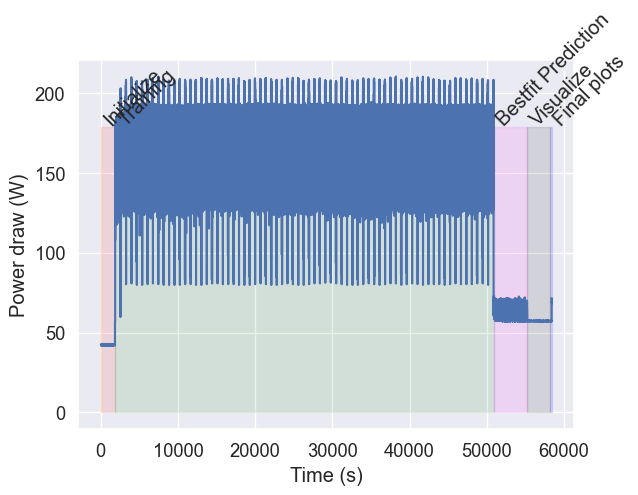

In [131]:
list_of_filenames = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70)]
                     # ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35/gpu0.log', 35)]
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25/gpu0.log', 25),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29/gpu0.log', 29),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33/gpu0.log', 33),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35/gpu0.log', 35)]

for entry  in files:
    # 'gpulog': 'data\\card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35\\gpu0.log'}]
    name_of_gpu = entry.gpulog.split('_gpu_count')[0].split('card_name_')[1]

    print (f"Generate output for Epoch {entry.epoch}")
    energylog = read_energy(entry.gpulog)
    eventlog = read_eventlog(entry.eventlog)

    t0_energy = energylog.time.iloc[0]
    t0_events = eventlog.time.iloc[0]

    t0 = min(t0_events, t0_energy)

    energylog["time"] = energylog["time"] - t0
    eventlog["time"] = eventlog["time"] - t0

    eventlog["time"] = eventlog["time"] / np.timedelta64(1, 's') - 5 * 60 * 60
    energylog["time"] = energylog["time"] / np.timedelta64(1, 's')

    # display(eventlog)

    # display(energylog)

    plot_events_and_energy(energylog, eventlog, entry.epoch)
    image_file = Shell.map_filename(f'./data/{name_of_gpu}-shaded-energy-{entry.epoch}-epochs.png').path
    plt.savefig(image_file, bbox_inches='tight')
    image_file = Shell.map_filename(f'./data/{name_of_gpu}-shaded-energy-{entry.epoch}-epochs.pdf').path
    plt.savefig(image_file, bbox_inches='tight')
    plt.show()
